# A CNN Mnist Model

In [ ]:
%install '.package(path: "$cwd/FastaiNotebook_05b_early_stopping")' FastaiNotebook_05b_early_stopping

Installing packages:
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_05b_early_stopping")
		FastaiNotebook_05b_early_stopping
With SwiftPM flags: []
Working in: /tmp/tmp6ykj4bvj
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/JustHTTP/Just
Completed resolution in 2.91s
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.2
Cloning https://github.com/JustHTTP/Just
Resolving https://github.com/JustHTTP/Just at 0.7.1
Compile Swift Module 'Just' (1 sources)
Compile Swift Module 'Path' (9 sources)
Compile Swift Module 'FastaiNotebook_05b_early_stopping' (9 sources)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Linking ./.build/x86_64-unknown-linux/debug/libjupyterInstalledPackages.so
Initializing Swift...
Loading library...
Installation complete!


## Load data

In [ ]:
import FastaiNotebook_05b_early_stopping
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [ ]:
// export
import Path
import TensorFlow
import Python

In [ ]:
let plt = Python.import("matplotlib.pyplot")

In [ ]:
let data = mnistDataBunch(flat: false, bs: 512)

In [ ]:
let firstBatch = data.train.first(where: { _ in true })!
let batchShape = firstBatch.xb.shape
let batchSize = batchShape.dimensions[0]
let exampleSideSize = batchShape.dimensions[1]
assert(exampleSideSize == batchShape.dimensions[2])
print("Batch size: \(batchSize)")
print("Example side size: \(exampleSideSize)")

let classCount = firstBatch.yb.shape.dimensions[0]
print("Class count: \(classCount)")

Batch size: 512
Example side size: 28
Class count: 512


In [ ]:
//export 
public struct CnnModel: Layer {
    public var reshapeToSquare: Reshape<Float>
    public var conv1: FAConv2D<Float>
    public var conv2: FAConv2D<Float>
    public var conv3: FAConv2D<Float>
    public var conv4: FAConv2D<Float>
    public var pool = FAAvgPool2D<Float>(poolSize: (2, 2), strides: (1, 1)) //TODO: replace by AvgPool
    public var flatten = Flatten<Float>()
    public var linear: FADense<Float>
    
    public init(sizeIn: Int, channelIn:Int, channelOut:Int, nFilters:[Int]) {
        reshapeToSquare = Reshape<Float>([-1, Int32(sizeIn), Int32(sizeIn), Int32(channelIn)])
        conv1 = FAConv2D<Float>(
            filterShape: (5, 5, 1, nFilters[0]), 
            strides: (2, 2), 
            padding: .same, 
            activation: relu)
        conv2 = FAConv2D<Float>(
            filterShape: (3, 3, nFilters[0], nFilters[1]),
            strides: (2, 2),
            padding: .same,
            activation: relu)
        conv3 = FAConv2D<Float>(
            filterShape: (3, 3, nFilters[1], nFilters[2]),
            strides: (2, 2),
            padding: .same,
            activation: relu)
        conv4 = FAConv2D<Float>(
            filterShape: (3, 3, nFilters[2], nFilters[3]),
            strides: (2, 2),
            padding: .same,
            activation: relu)
        linear = FADense<Float>(inputSize: nFilters[3], outputSize: channelOut)
    }
    
    @differentiable
    public func applied(to input: Tensor<Float>, in context: Context) -> Tensor<Float> {
        // There isn't a "sequenced" defined with enough layers.
        let intermediate =  input.sequenced(
            in: context,
            through: reshapeToSquare, conv1, conv2, conv3, conv4)
        return intermediate.sequenced(in: context, through: pool, flatten, linear)
    }
}

In [ ]:
let model = CnnModel(sizeIn:28, channelIn: 1, channelOut: 10, nFilters: [8, 16, 32, 32])

In [ ]:
// Test that data goes through the model as expected.
let predictions = model.applied(to: firstBatch.xb, in: Context(learningPhase: .training))
print(predictions.shape)
print(predictions[0])

TensorShape(dimensions: [512, 10])
[ 0.007230411, -0.010739702,  -0.03191483,  0.003506335,  0.008309381, -0.028648112,
    -0.021649, -0.020878375,  0.005120526,   0.01246003]


# Compare training on CPU and GPU

In [ ]:
let opt = SGD<CnnModel, Float>(learningRate: 0.4)
func modelInit() -> CnnModel { return CnnModel(sizeIn:28, channelIn: 1, channelOut: 10, nFilters: [8, 16, 32, 32]) }
let learner = Learner(data: data, lossFunction: softmaxCrossEntropy, optimizer: opt, initializingWith: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))

In [ ]:
// This happens on the GPU (if you have one and it's configured correctly).
// I tried this on a GCE 8vCPU 30GB + Tesla P100:
// - time: ~4.3s
// - nvidia-smi shows ~10% GPU-Util while this is running
time {
    try! learner.fit(1)
}

Epoch 0: [0.34945536, 0.8948]                                                   
22631.196462 ms                                                               


In [ ]:
// This happens on the CPU.
// I tried this on a GCE 8vCPU 30GB + Tesla P100:
// - time: ~6.3s
// - nvidia-smi shows 0% GPU-Util while this is running
time {
    withDevice(.cpu) {
        try! learner.fit(1)
    }
}

Epoch 0: [0.14942531, 0.9546]                                                   
25278.844949 ms                                                               


# Collect Layer Activation Statistics

In [ ]:
class ActivationStatistics: LayerDelegate<Tensor<Float>> {
    var activationMeans: [Float] = []
    var activationStds: [Float] = []    
    override func didProduceActivation(_ activation: Tensor<Float>, in context: Context) {
        guard context.learningPhase == .training else { return }
        activationMeans.append(activation.mean().scalar!)
        activationStds.append(activation.standardDeviation().reshaped(to: []).scalar!)
    }
}

In [ ]:
extension KeyPathIterable {    
    mutating func initializeLayerDelegates<T>(with initializer: () -> LayerDelegate<T>) {
        for kp in recursivelyAllWritableKeyPaths(to: LayerDelegate<T>.self) {
            self[keyPath: kp] = initializer()
        }
    }
    
    func layerDelegates<T, D: LayerDelegate<T>>(havingType: D.Type) -> [D] {
        var result: [D] = []
        for kp in recursivelyAllWritableKeyPaths(to: LayerDelegate<T>.self) {
            guard let d = self[keyPath: kp] as? D else { continue }
            result.append(d)
        }
        return result
    }
}

In [ ]:
let learner = Learner(data: data, lossFunction: softmaxCrossEntropy, optimizer: opt, initializingWith: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])

learner.model.initializeLayerDelegates(with: { ActivationStatistics() })

In [ ]:
// This LayerDelegate stuff slows it down to ~6s/epoch.
time {
    try! learner.fit(2)
}

Epoch 0: [0.5438706, 0.8331]                                                    
Epoch 1: [0.15849537, 0.9508]                                                   
42425.841089 ms                                                               


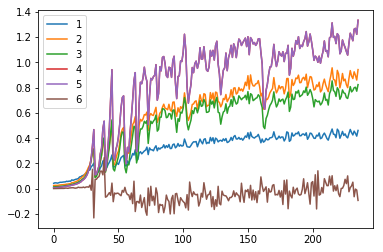

None


In [ ]:
let activationStatistics = learner.model.layerDelegates(havingType: ActivationStatistics.self)
for stats in activationStatistics {
    plt.plot(stats.activationMeans)
}
plt.legend(Array(1...activationStatistics.count))
plt.show()

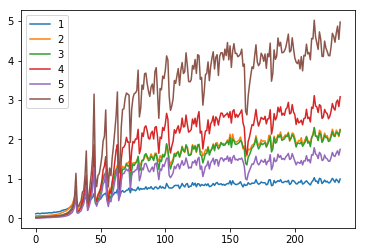

None


In [ ]:
for stats in activationStatistics {
    plt.plot(stats.activationStds)
}
plt.legend(Array(1...activationStatistics.count))
plt.show()

## Export

In [ ]:
notebookToScript(fname: (Path.cwd / "06_cuda.ipynb").string)